In [1]:
from functools import partial
from itertools import chain
import numpy as np
from scipy.integrate import RK45  #type: ignore

import matplotlib as mpl  #type: ignore
import matplotlib.pyplot as plt  #type: ignore
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 14

from numpy import ndarray
from typing import List, Tuple, Iterable, Any, Union, Optional, Callable

In [18]:
def seir(p: Iterable[float], t: float, x: Iterable[float]) -> ndarray:
    S, E, I, R, D, N = *x, np.sum(x)
    β, γ, σ, μ, ν, ρ = p
    
    dS = μ * (N - S) - β * (I) * S / N - ν * S
    dE = β * I * S / N - (μ + σ) * E
    dI = σ * E - (μ + γ) * I
    dR = (1 - ρ) * γ * I - μ * R + ν * S
    dD = ρ * γ * I
    
    return np.array([dS, dE, dI, dR, dD])

In [49]:
def rk4(f: Callable[[Any], Any], init: Iterable[float], param: Iterable[float], stp: float, t: float):
    """
    
    """
    steps = int(t // stp) + 1
    res = np.zeros((steps, 1 + len(init)))
    res[0] = [0, *init]
    
    for i in range(1, steps):
        prevVals = res[i-1][1:]
        xi = stp * i
    

        k1 = stp * f(param, xi, prevVals)
        k2 = stp * f(param, xi + stp / 2, prevVals + k1 / 2)
        k3 = stp * f(param, xi + stp / 2, prevVals + k2 / 2)
        k4 = stp * f(param, xi, prevVals + k3)

        adjFactor = prevVals + 1/6 * k1
        adjFactor += 1/3 * k2
        adjFactor += 1/3 * k3
        adjFactor += 1/6 * k4

        res[i] = [xi, *adjFactor]
            
    return res

In [41]:
β = 0.9
γ = 0.2
σ = 0.5
μ = 0.0
ν = 0.0
ρ = 0.01
p = (β, γ, σ, μ, ν, ρ)

S = 350e6
E = 0
I = 100
R = 0
D = 0
x = (S, E, I, R, D)

n = 80
step = 0.1
t0 = 0.0

In [50]:
result = rk4(seir, x, p, step, n)
time, res_S, res_E, res_I, res_R, res_D = [result[:, i] for i in range(result.shape[1])]
total_I = I + E + S - res_S
growth = np.gradient(np.log(total_I), time)

In [46]:
ode = RK45(partial(seir, p), t0, x, n, first_step=step, max_step=step)

result = []
while ode.status == 'running':
    ode.step()
    result.append([ode.t, *ode.y])
time, res_S, res_E, res_I, res_R, res_D = np.array(list(zip(*result)))

total_I = I + E + S - res_S
growth = np.gradient(np.log(total_I), time)

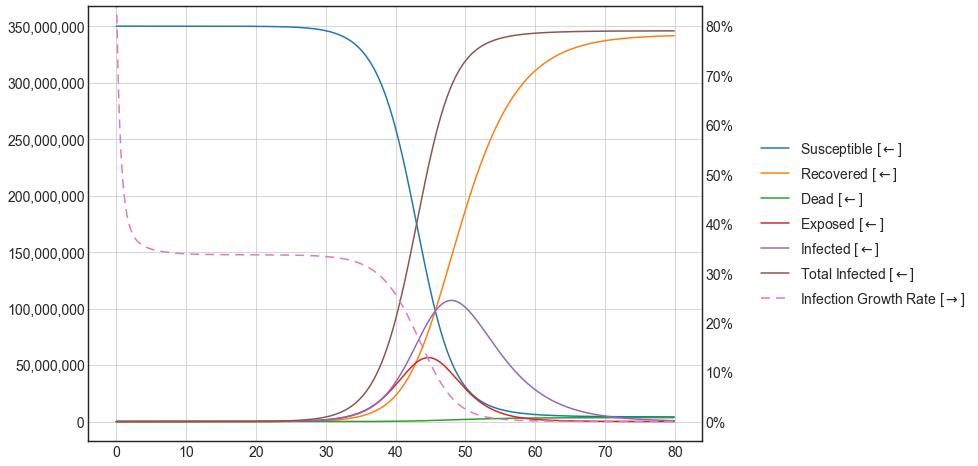

In [51]:
fig, ax = plt.subplots(figsize=(11, 8))


ax.plot(time, res_S, label=r'Susceptible [$\leftarrow$]')
ax.plot(time, res_R, label=r'Recovered [$\leftarrow$]')
ax.plot(time, res_D, label=r'Dead [$\leftarrow$]')
ax.plot(time, res_E, label=r'Exposed [$\leftarrow$]')
ax.plot(time, res_I, label=r'Infected [$\leftarrow$]')
ax.plot(time, total_I, label=r'Total Infected [$\leftarrow$]')
ax2 = ax.twinx()
ax2.plot(time, growth * 100, c='C6', ls=(0,(6,4)), label=r'Infection Growth Rate [$\rightarrow$]')

handles, labels = [list(chain.from_iterable(_)) for _ in zip(*(
                       _.get_legend_handles_labels() for _ in (ax, ax2)
                   ))]

ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5), handles=handles, labels=labels)
ax.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:3,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}%'))
ax2.set(xlabel='Time [days]', ylim=(-4, 84))

# plt.savefig('cartesian.png', dpi=100, bbox_inches='tight')
plt.show()

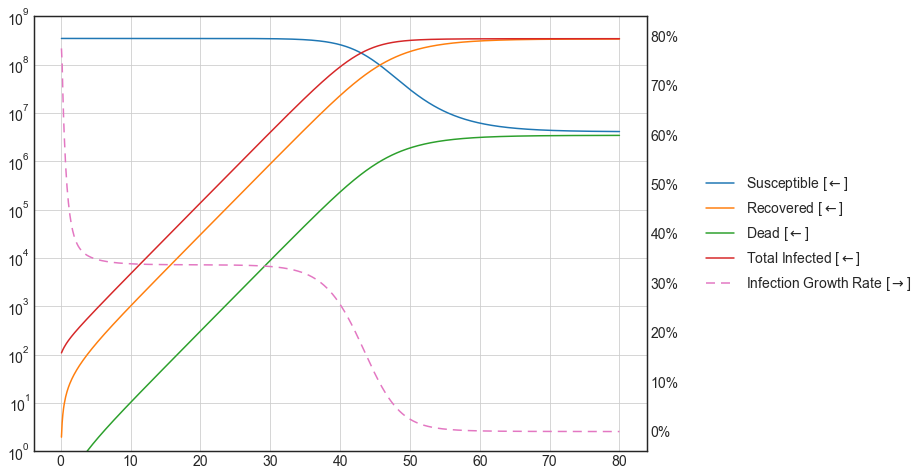

In [9]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.plot(time, res_S, label=r'Susceptible [$\leftarrow$]')
ax.plot(time, res_R, label=r'Recovered [$\leftarrow$]')
ax.plot(time, res_D, label=r'Dead [$\leftarrow$]')
ax.plot(time, total_I, label=r'Total Infected [$\leftarrow$]')
ax2 = ax.twinx()
ax2.plot(time, growth * 100, c='C6', ls=(0,(6,4)), label=r'Infection Growth Rate [$\rightarrow$]')

handles, labels = [list(chain.from_iterable(_)) for _ in zip(*(
                       _.get_legend_handles_labels() for _ in (ax, ax2)
                   ))]

ax.legend(loc='right', bbox_to_anchor=(1.45, 0.5), handles=handles, labels=labels)
ax.grid()
ax.set(yscale='log', ylim=(1, 1e9))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}%'))
ax2.set(xlabel='Time [days]', ylim=(-4, 84))

plt.savefig('log.png', dpi=100, bbox_inches='tight')